# Finetuning Segment Anything Model (SAM) for flood inundation mapping
> * Data Science
> * Deep Learning and pixel classification

# Table of Contents

* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Export training data](#4)
* [Model training](#5)
  * [Get training data](#6)
  * [Prepare data](#7)
  * [Visualize training data](#8)
  * [Load model architecture](#9)
  * [Train the model](#10)
  * [Visualize results in validation set](#11)
  * [Evaluate model performance](#12)
  * [Save the model](#13)
* [Model inferencing](#14)
* [Results visualization](#15)
  * [Flood inundation mapping](#16)
  * [Estimation of flood inundated area](#17)
  * [Infrastructural inundation assessment](#18)
* [Conclusion](#19)

## Introduction<a class="anchor" id="1"></a>

Flooding is one of the most frequent and costly forms of natural disasters. They often strike without warning and can occur when large volumes of water fall in a short time, causing flash floods. Flood mapping is typically performed using aerial observations and ground surveys. However, when flooding is widespread, these methods become prohibitively expensive and time consuming. Furthermore, aerial observation and optical imagery can often prove difficult, if not impossible, due to obstructive weather conditions. During flooding conditions, clouds can prevent the use of optical satellite imagery for visualization and analysis. In these instances, synthetic-aperture radar (SAR) allows us to penetrate through clouds and hazy atmospheric conditions to continuously observe and map flooding.

North India faced severe rainfall in the first two weeks of July 2023 due to the interaction between Western Disturbances (a low pressure system originating from the Mediterranean region) and Monsoon trough (a low pressure zone located in East west direction from Northwest Rajasthan towards the Bay of Bengal). From 9 to 13 July large volume of water was released from Hathnikund Barrage on the Yamuna river. This raised the water level downstream to the highest level since 1978 floods, causing flooding in Delhi and the adjoining areas.

In such situations, mapping of flood affected areas can help in quick and efficient disaster management and relief efforts. Here, we have used the SamLora deep learning model which finetunes the foundational pixel classification model by Meta, Segment Anything Model (SAM). SamLoRA allows the use of the underlying learnings of SAM and quickly finetunes on a smaller dataset to work for a particular use case.

## Necessary imports<a class="anchor" id="2"></a>

In [1]:
import os
from datetime import datetime
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, SamLoRA
from arcgis.raster import Raster, convert_raster_to_feature
from arcgis.features.manage_data import overlay_layers
from arcgis.features.analysis import dissolve_boundaries

## Connect to your GIS<a class="anchor" id="3"></a>

In [2]:
from arcgis import GIS
gis = GIS('home')

## Export training data<a class="anchor" id="4"></a>

We have used the Sentinel-1 SAR imagery as the input raster for the training dataset. A composite of VV, VH & VV/VH band has been created which works best for floods, according to the literature.

<Item title:"yamuna_flood_input_raster" type:Tiled Imagery Layer owner:api_data_owner>
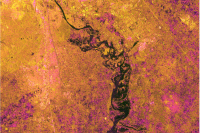

In [3]:
input_raster = gis.content.get("3b55a6f703234c278e76704e6ff50666")
input_raster

The feature layer contains a single classes for water bodies. The feature layer will be used as the `Input Feature Class` in the `Export Training Data For Deep Learning` tool.

In [4]:
label_raster = gis.content.get("cb0e42c0ae714c5e90b09aeb2add2baa")
label_raster

<Item title:"yamuna flood_labels" type:Feature Layer Collection owner:api_data_owner>

The polygon feature class will be used as `Input Mask Polygons` in the `Export Training Data For Deep Learning` tool to delineate the area where image chips will be created.

In [5]:
aoi = gis.content.get("8fcf0ba8de7947c3b696778a1fdc88ea")
aoi

<Item title:"yamuna_flood_aoi_mask" type:Feature Layer Collection owner:api_data_owner>

The [Export Training Data For Deep Learning](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool is used to prepare training data for training a deep learning model. The tool is available in both `ArcGIS Pro` and `ArcGIS Enterprise`.

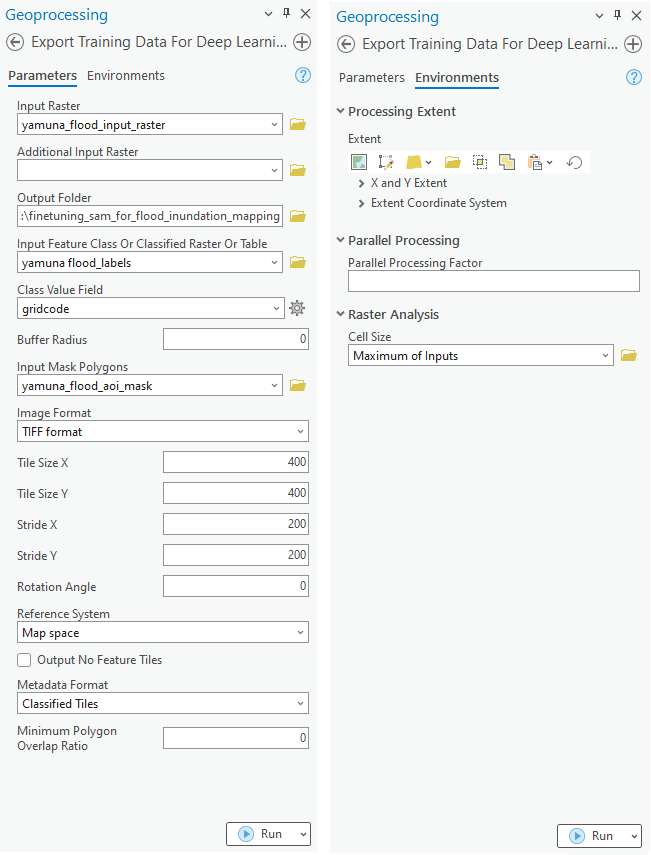

Next, we will utilize Jupyter Notebooks. Documentation on how to install and setup the necessary environment is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/).

## Model training<a class="anchor" id="5"></a>

### Get training data<a class="anchor" id="6"></a>

We have already exported the data, and it can be directly downloaded using the following steps:

In [6]:
training_data = gis.content.get('5dff2d39729c44949b3024c1f1ead403')
training_data

<Item title:"finetuning_sam_for_flood_inundation_mapping" type:Image Collection owner:api_data_owner>

In [7]:
filepath = training_data.download(file_name=training_data.name)

In [8]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [9]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

### Prepare data<a class="anchor" id="7"></a>

We will specify the path to our training data and a few hyperparameters. 

- `path`: path of the folder/list of folders containing training data.
- `batch_size`: Number of images your model will train on each step inside an epoch. Depends on the memory of your graphic card.
- `chip_size`: The same as the tile size used while exporting the dataset to ensure the entire chip is used at once and not cropped.

In [10]:
data = prepare_data(data_path, batch_size=4, chip_size=400)

### Visualize training data<a class="anchor" id="8"></a>

To get a sense of what the training data looks like, the `show_batch()` method will randomly select a few training chips and visualize them.

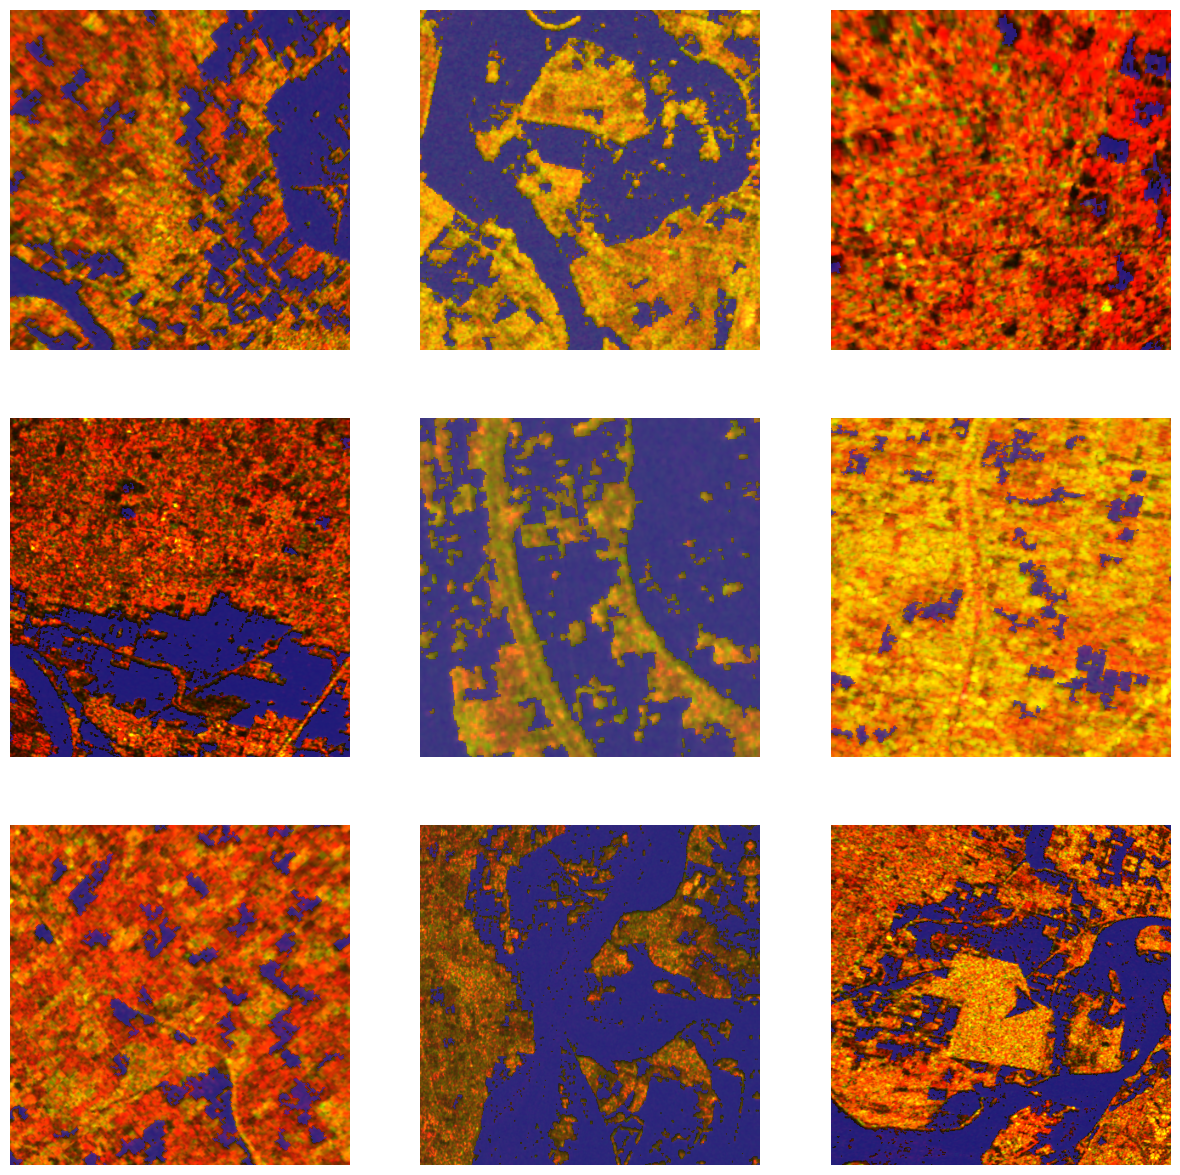

In [11]:
data.show_batch(alpha=0.8)

### Load model architecture<a class="anchor" id="9"></a>

The code below will create a SamLoRA model. It is based on the Segment Anything Model (SAM) by MetaAI. It uses a Low Rank Adaptation to finetune the model for a specific task. This model can be used for 'pixel classification'. By default, this model will be loaded with a `vit_b` backbone. `vit_h` or `vit_l` backbone can be chosen by providing the `backbone` parameter. More details about SamLoRA can be found [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#samlora).

In [12]:
model = SamLoRA(data)

### Train the model<a class="anchor" id="10"></a>

Next, we will train the model for a few epochs.

In [13]:
model.fit(epochs=10, lr=0.001)

epoch,train_loss,valid_loss,accuracy,dice,time
0,0.755435,0.652948,0.787804,0.284233,00:21
1,0.724142,0.695130,0.350940,0.388395,00:10
2,0.703178,0.324360,0.857022,0.723125,00:10
3,0.598624,0.247313,0.921513,0.802098,00:10
4,0.515951,0.204478,0.923592,0.820371,00:10
5,0.460703,0.234249,0.924720,0.799366,00:10
6,0.413691,0.201680,0.929974,0.824633,00:10
7,0.377130,0.194776,0.930521,0.831087,00:10
8,0.356235,0.186328,0.930645,0.837745,00:10
9,0.334790,0.187167,0.930861,0.836978,00:10


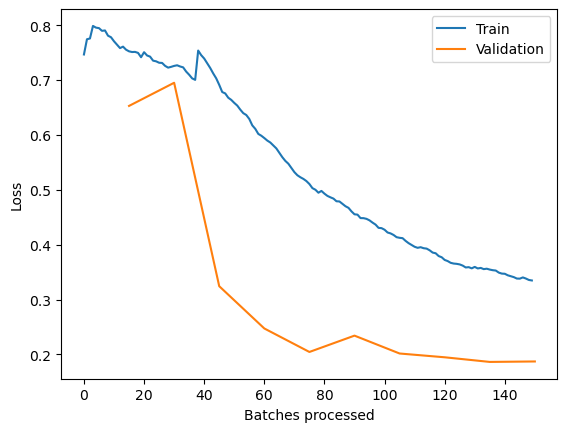

In [14]:
model.plot_losses()

### Visualize results in validation set<a class="anchor" id="11"></a>

It is a good practice to see the results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model we trained. In the following code `alpha` parameter sets the transparency of the results.

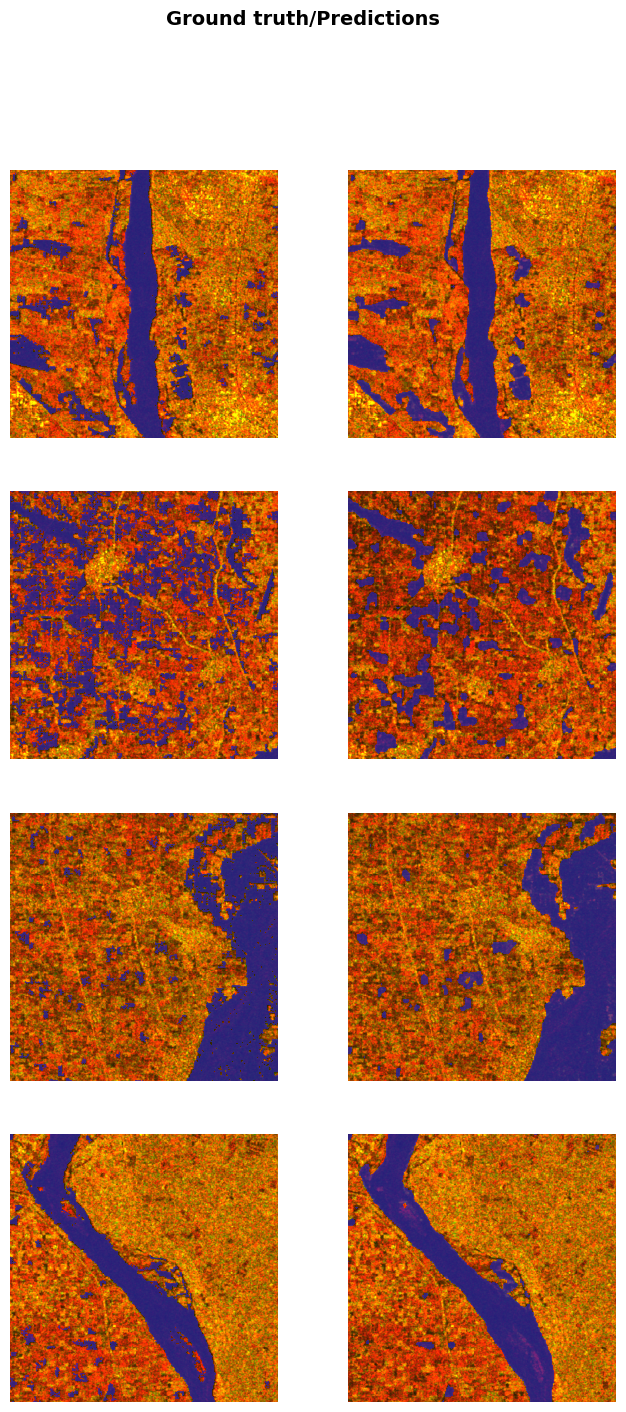

In [15]:
model.show_results(alpha=0.8)

### Evaluate model performance<a class="anchor" id="12"></a>

In [16]:
model.accuracy()

0.9306446313858032

`arcgis.learn` provides the `mIOU()` method that computes the mean Intersection Over Union (IOU) of the results provided by the model on the validation set for each class. 

In [17]:
model.mIOU()

{'0': 0.9152871021073077, '1': 0.7232920825582878}

To calculate the precision, recall, and f1 score for each class use the `per_class_metrics` function.

In [18]:
model.per_class_metrics()

,NoData,1
precision,0.949330,0.860626
recall,0.962298,0.819254
f1,0.955770,0.839431


### Save the model<a class="anchor" id="13"></a>

We will save the model that we trained as a 'Deep Learning Package' ('.dlpk' format). A Deep Learning Package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within the training data folder.

In [19]:
model.save('samlora_yamuna_flood_model', publish=True, overwrite=True)

Published DLPK Item Id: b25d811c5caa4f71b30cd82356630894


WindowsPath('C:/temp/data/samlora_yamuna_flood_model')

## Model inferencing<a class="anchor" id="14"></a>

Using ArcGIS Pro, we can use the trained model on a test image/area to classify flood inundated areas in the SAR satellite image.

After training the `SamLoRA` model and saving the weights for classifying images, we can use the [Classify Pixels Using Deep Learning tool](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) tool available in [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) and [ArcGIS Enterprise](https://enterprise.arcgis.com/en/portal/latest/use/classify-pixels-using-deep-learning.htm) for inferencing.

In [20]:
flood_model = gis.content.get('b25d811c5caa4f71b30cd82356630894')
flood_model

<Item title:"samlora_yamuna_flood_model" type:Deep Learning Package owner:api_data_owner>

In [21]:
raster_for_inferencing = gis.content.get('68e8d7e211184a3baf464b48785607d3')
raster_for_inferencing

<Item title:"yamuna_flood_inference_raster" type:Tiled Imagery Layer owner:api_data_owner>

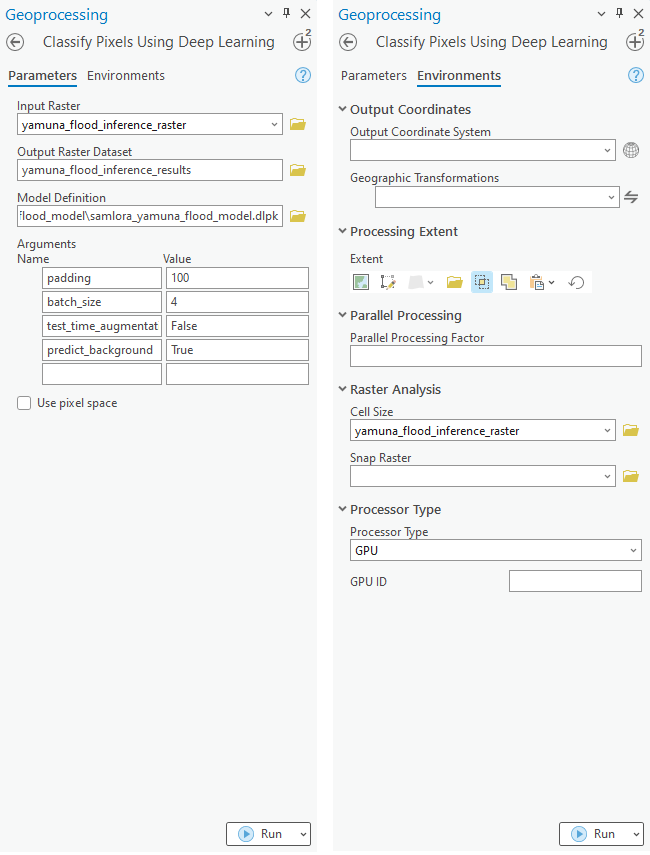

## Results visualization<a class="anchor" id="15"></a>

The classified output raster is generated using ArcGIS Pro. The output raster is published on the portal for visualization.

In [22]:
sar_ras2 = gis.content.get('68e8d7e211184a3baf464b48785607d3')
inf_ras2 = gis.content.get('3ebe870417894bb99faf8d90a5c78be0')

In [23]:
from arcgis.raster import colormap
inf_cmap2 = colormap(inf_ras2.layers[0], colormap=[[1, 7, 42, 108],[2, 0, 206, 209]])

### Create map widgets
Three map widgets are created showing flood affected areas in Delhi and the adjoining region.

In [24]:
map1 = gis.map('Delhi, India', 11)
map1.basemap='satellite'
map2 = gis.map('Delhi, India', 11)
map2.add_layer(sar_ras2)
map3 = gis.map()
map3.add_layer(sar_ras2)
map3.add_layer(inf_cmap2)

### Set the map layout

In [25]:
from ipywidgets import HBox, VBox, Label, Layout

In [26]:
map1.sync_navigation(map2)
map2.sync_navigation(map3)

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [27]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1,hb2=HBox([Label('True Colour Image'),Label('Sentinel-1 Imagery'),Label('Predictions'),]),\
                HBox([Label('True Colour Image'),Label('Sentinel-1 Imagery'),Label('Predictions')])
hb1.layout,hb2.layout=hbox_layout,hbox_layout

### Flood inundation mapping<a class="anchor" id="16"></a>

The resulting predictions are provided as a map for better visualization. The results show the spatial distribution of flood water in the Delhi region during the 2023 floods. Sentinel-1 imagery of July 2023 are used for the analysis.

In [28]:
VBox([hb1,HBox([map1,map2,map3])])

Three map widgets were created. The left widget displays natural color high resolution satellite imagery prior to flooding, the middle widget displays the Sentinel-1 imagery during the flood event, and the right map widget displays the predictions of the trained SamLoRA model. In the maps, Delhi and other cities of the National Capital Region of India can be seen on both sides of the Yamuna river. The model is able to identify all the flooded regions. The True Color Imagery can be used for visual interpretation for model accuracy.

## Conclusion<a class="anchor" id="19"></a>

In this notebook, we have demonstrated how to use a SamLoRA to finetune SAM model with ArcGIS API for Python and extract flood area with a small dataset and short training. We covered how Sentinel-1 SAR data can be used for flood inundation mapping and monitoring. This process involved steps to prepare the input data, train a pixel-based classification model, visualize the results, generate accuracy metrics, and inferencing results on a test raster.